<a href="https://colab.research.google.com/github/elly760/AI-projects/blob/main/RESNET_Image%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the requred library for perorming some tasks
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**INTRODUCTION OF THE PROJECT: **
In this project, we aim to develop a sophisticated garbage classification system leveraging the ResNet50 architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation. A notable challenge encountered is the inherent class imbalance within the dataset, prompting the exploration of data augmentation, and varied evaluation metrics. The project journey encompasses a comprehensive dataset analysis, addresses the imbalance, and delves deep into building and evaluating models both from scratch and through transfer learning with ResNet50.

---



**OBJECTIVES**
Dataset Exploration: Dive into the garbage dataset, emphasizing class imbalances.
Tackle Imbalance: Utilize class weights in the loss function to address dataset disparities.
Implement Data Augmentation: Enhance model generalization and combat overfitting.
Construct ResNet50: Design a custom ResNet50 for garbage classification from scratch.
Employ Transfer Learning: Leverage a pre-trained ResNet50, adapting it for our specific dataset.
Evaluate Models: Assess both models' performance using varied metrics to ensure reliable classification.

In [ ]:
# DATASET ANALYSIS
dataset_path="/content/drive/MyDrive/ict_ai_question/garbage_photos_train"

In [ ]:
# lests go throuh inside the dataset ad the navigate through
# different folders containing the garbage types
# counting the picyures and then checking if the sizes are similar
# then display the images for each garbage class
# RETRIEVE THE NAMES OF ALL FOLDERS
garbage_types=os.listdir(dataset_path)

# set to store image dimensions fro each dataset
all_dimensions_set=set()

# lets now iterarate through each type of folder to process the image
for garbage_type in garbage_types:
  folder_path=os.path.join(dataset_path,garbage_type)
  # verify if the current item is in the directory
  if os.path.isdir(folder_path):
    image_files=[f for f in os.listdir(folder_path) if f.endswith((".jpg",".png"))]
    num_images=len(image_files)
    image_files
    print(f"{garbage_type} folder contains {num_images} images.")
    # loop over each image to check the dimensions
    for image_file in image_files:
      image_path=os.path.join(folder_path,image_file)
      with Image.open(image_path) as img:
        width,height=img.size
        channels=len(img.getbands())
        all_dimensions_set.add((width, height, channels))
  # lets check if all the images in the dataset have the sa


cigarette_butt folder contains 80 images.
cardboard_box folder contains 80 images.
egg_shell folder contains 80 images.
fruit_peel folder contains 80 images.
battery folder contains 80 images.


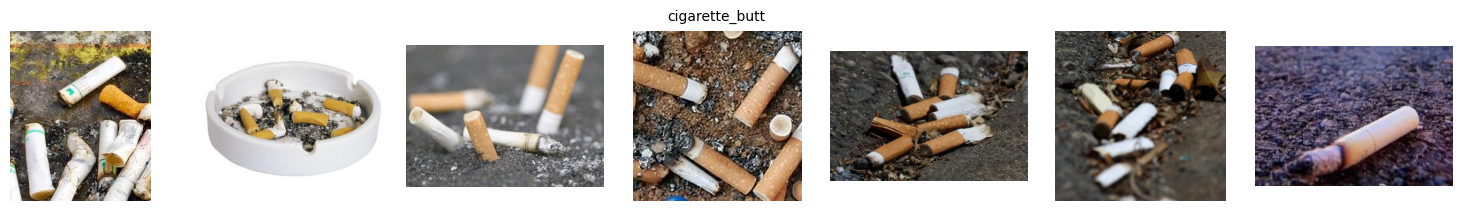

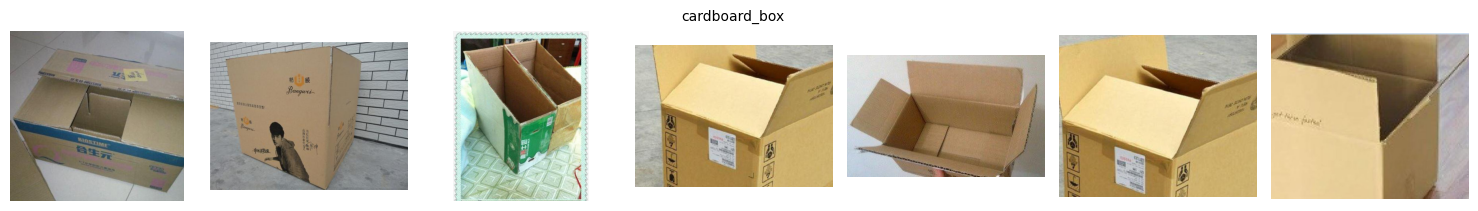

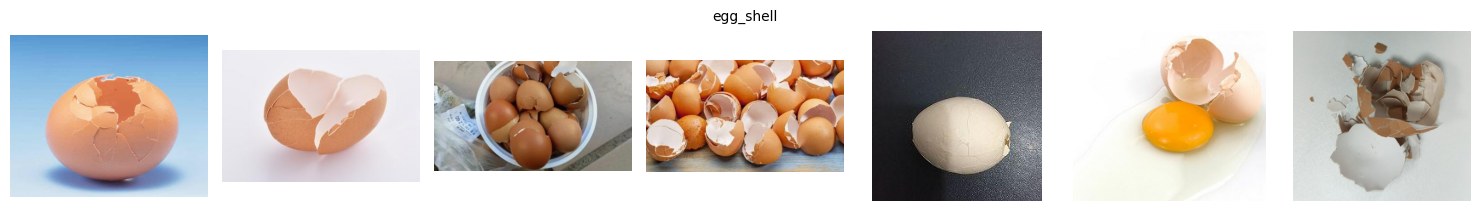

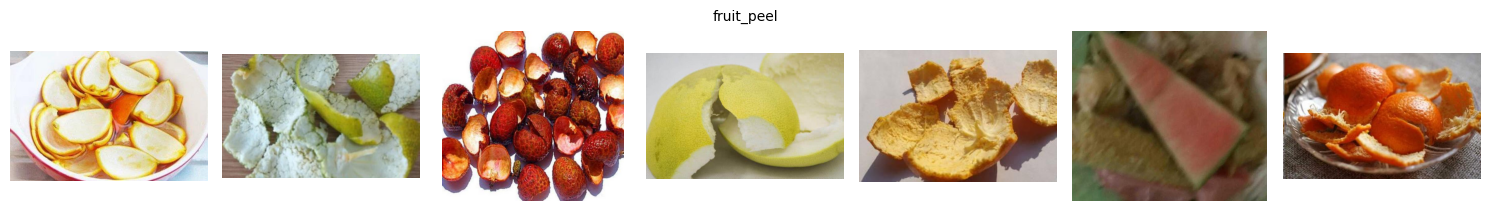

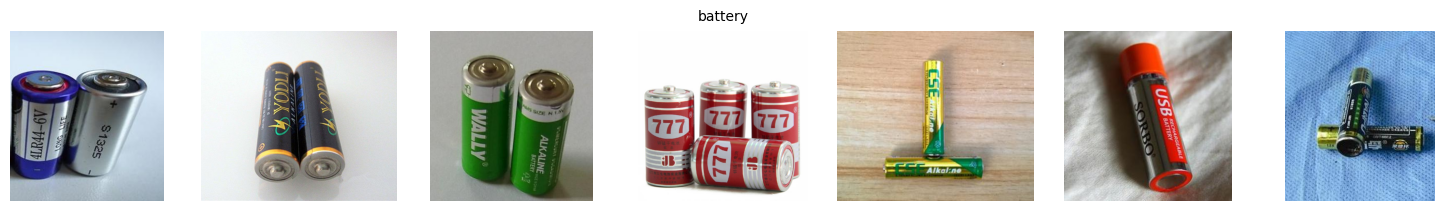

In [ ]:
# DISPLAYING THE IMAGES FROM THE DATASET
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select the first 10 images
        image_files = image_files[:7]

        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=10, y=1.03)
        plt.show()

In [ ]:
# LETS WORK ON THE DATA PREPARATION
# This is becase we have all the images scattered over the folders in diferent classess
# and therefore we need a unified view of our images for easy manupulation
# initialise the empty list for storing the images according to their labels
data=[]
for garbage_type in garbage_types:
  for file in os.listdir(os.path.join(dataset_path,garbage_type)):
    data.append((os.path.join(dataset_path,garbage_type,file),garbage_type))

# lets now convert the collected data into dataframe
df=pd.DataFrame(data,columns=["filepath","label"])
df.head()


,filepath,label
0,/content/drive/MyDrive/ict_ai_question/garbage...,cigarette_butt
1,/content/drive/MyDrive/ict_ai_question/garbage...,cigarette_butt
2,/content/drive/MyDrive/ict_ai_question/garbage...,cigarette_butt
3,/content/drive/MyDrive/ict_ai_question/garbage...,cigarette_butt
4,/content/drive/MyDrive/ict_ai_question/garbage...,cigarette_butt


In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 10

# Load pre-trained ResNet50 model without top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and test data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ict_ai_question/garbage_photos_train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/ict_ai_question/garbage_photos_test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.n // BATCH_SIZE
)


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Epoch 1/10
12/12 [==============================] - 134s 10s/step - loss: 1.9712 - accuracy: 0.2255 - val_loss: 1.8705 - val_accuracy: 0.1979
Epoch 2/10
12/12 [==============================] - 106s 9s/step - loss: 1.7329 - accuracy: 0.2826 - val_loss: 1.6153 - val_accuracy: 0.1979
Epoch 3/10
12/12 [==============================] - 102s 8s/step - loss: 1.6505 - accuracy: 0.2772 - val_loss: 1.6664 - val_accuracy: 0.3958
Epoch 4/10
12/12 [==============================] - 101s 9s/step - loss: 1.5914 - accuracy: 0.2717 - val_loss: 1.6615 - val_accuracy: 0.3229
Epoch 5/10
12/12 [==============================] - 104s 9s/step - loss: 1.5251 - accuracy: 0.3342 - val_loss: 1.4593 - val_accuracy: 0.4062
Epoch 6/10
12/12 [==============================] - 106s 9s/step - loss: 1.4540 - accuracy: 0.3750 - val_loss: 1.4192 - val_accuracy: 0.3958
Epoch 7/10
12/12 [==============================] - 105s 9s/step - loss

In [ ]:
evaluation_results = model.evaluate(test_generator)
print("Evaluation Loss:", evaluation_results[0])
print("Evaluation Accuracy:", evaluation_results[1])


4/4 [==============================] - 21s 5s/step - loss: 1.3993 - accuracy: 0.4200
Evaluation Loss: 1.3992544412612915
Evaluation Accuracy: 0.41999998688697815


In [ ]:
from tensorflow.keras.utils import to_categorical
import os

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/ict_ai_question/garbage_photos_train'

# Retrieve the names of all folders (garbage types) in the dataset
garbage_types = os.listdir(dataset_path)

# Define lists to store images and labels
X_train = []
y_train = []

# Iterate through each type of garbage folder to process the images
for idx, garbage_type in enumerate(garbage_types):
    folder_path = os.path.join(dataset_path, garbage_type)
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png"))]
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            # Load the image, preprocess, and append to X_train
            # Example preprocessing code:
            # img = preprocess_image(image_path)
            # X_train.append(img)
            X_train.append(image_path)
            # Append the corresponding label (encoded as an integer) to y_train
            y_train.append(idx)  # Assigning a unique label index for each garbage type

# Convert the lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, len(garbage_types))

# Now you can use X_train (images) and y_train_encoded (one-hot encoded labels) for training your model


In [ ]:
# lets now verify that the dimensions in the trainig and the validation
# sets closely to the overall distribution


In [ ]:
# RESNET CALSSIFICATION IMPLIMENTATION
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
# lets now define the function for creating a single block  of the resnet architecture.
# This layer consits of the conv layer followed by the Batch normalization layer and then
# the activation function(DEFAULT ReLu)
def resnet_block(x, filters, kernel_size=3,strides=1,activation="relu"):
  y=layers.Conv2D(filters,kernel_size=kernel_size,strides=strides,padding="same")(x)
  y=layers.BatchNormalization()(y)
  if activation:
    y=layers.Activation(activation)(y)
  return y



In [ ]:
def resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = resnet_block(inputs, 64)
    for _ in range(3):
        y = resnet_block(x, 64)
        y = resnet_block(y, 64, activation=None)
        x = layers.Add()([x, y])  # Fix here, provide input tensors to Add() function
        x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model


In [ ]:
# setting up the input shape for the images ie hieght, width channels and
# the number of output classes for the ouput classes of the gagrbage classification
input_shape=(224,224,3)
num_classes=5

In [ ]:
# creating the model by calling the renet function that have been defined with
# with specific input size and the number of class
model=resnet(input_shape,num_classes)


In [ ]:
# compiling the model with Adam optimizzer, categorical cross entropy loss function
model.compile(optimizer="adam", loss="categorical_crossentropy")
metrics=["accuracy"]

In [ ]:
# displaying the summary of the model architectures
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 224, 224, 64)         256       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_7 (Activation)   (None, 224, 224, 64)         0         ['batch_normalization_7[

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

NameError: name 'model' is not defined

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you have your evaluation dataset stored in a folder with subfolders for each class
# Define the path to your evaluation dataset
eval_dataset_path = "/content/drive/MyDrive/ict_ai_question/garbage_photos_test"

# Define the list to store evaluation images and labels
X_eval = []
y_eval = []

# Retrieve the names of all folders (garbage types) in the evaluation dataset
garbage_types_eval = os.listdir(eval_dataset_path)

# Iterate through each type of folder to process the evaluation images
for idx, garbage_type in enumerate(garbage_types_eval):
    folder_path_eval = os.path.join(eval_dataset_path, garbage_type)
    if os.path.isdir(folder_path_eval):
        # List all image files in the current folder
        image_files_eval = [f for f in os.listdir(folder_path_eval) if f.endswith((".jpg", ".png"))]
        # Loop over each image to load and preprocess it
        for image_file_eval in image_files_eval:
            image_path_eval = os.path.join(folder_path_eval, image_file_eval)
            # Load the image
            img_eval = load_img(image_path_eval, target_size=(224, 224))  # Assuming target size is (224, 224)
            img_eval_array = img_to_array(img_eval)
            # Append the preprocessed image to X_eval
            X_eval.append(img_eval_array)
            # Append the corresponding label to y_eval
            y_eval.append(idx)  # Assigning a unique label index for each garbage type

# Convert the lists to numpy arrays
X_eval = np.array(X_eval)
y_eval = np.array(y_eval)

# Normalize pixel values of images
X_eval = X_eval / 255.0

# Print the shapes of X_eval and y_eval
print("Shape of X_eval:", X_eval.shape)
print("Shape of y_eval:", y_eval.shape)


Shape of X_eval: (100, 224, 224, 3)
Shape of y_eval: (100,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Assuming you have your training labels in y_train and evaluation labels in y_eval
# Ensure labels are one-hot encoded
y_train_encoded = to_categorical(train_df, num_classes)
y_eval_encoded = to_categorical(eval_df, num_classes)

# Compile the model with appropriate loss function and metrics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy'])

# Assuming your model has an output layer with num_classes units and softmax activation
# Example output layer: layers.Dense(num_classes, activation='softmax')


ValueError: invalid literal for int() with base 10: '/content/drive/MyDrive/ict_ai_question/garbage_photos_train/fruit_peel/img_3334_1621258420888.jpg'

In [ ]:
# Assuming you have a dataset ready for evaluation
# X_eval: Evaluation data (images)
# y_eval: Evaluation labels (ground truth)
# Evaluate the model on the evaluation dataset
eval_loss, eval_accuracy = model.evaluate(X_eval, y_eval)

print(f"Evaluation Loss: {eval_loss}")
print(f"Evaluation Accuracy: {eval_accuracy}")


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1919, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 5) are incompatible
